<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Григорьева Василиса Алексеевна

**Забавный факт о себе:**

На кр в последнем задании пропустила последний пункт, потому что думала, что в пдфке 2 страницы вместо 3х.....

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/12bya1HyWNMQ9jIMUoV9HgPCpI1akFCqr?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag, cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria.target_tags.values[:3]

array([list([822, 1261, 390]), list([1308, 1532, 390]), list([120])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [14]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [16]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [17]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [18]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNK"`.

In [19]:
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text)

df_vk['title_clean'] = df_vk.title.apply(normalise_text)

df_vk.loc[df_vk['snippet'].isna(), 'snippet'] = "#UNK#"
df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_text)

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [ ]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [ ]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [ ]:
from datetime import datetime


df.loc[:, 'date'] = pd.to_datetime(df.date)

df_test = df[(df.date >= datetime(2018, 12, 1)) & (df.date <= datetime(2018, 12, 31))]
df_val = df[(df.date >= datetime(2018, 10, 1)) & (df.date <= datetime(2018, 11, 30))]
df_train = df[df.date < datetime(2018, 10, 1)]

<ipython-input-23-110bfc04979d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'date'] = pd.to_datetime(df.date)
<ipython-input-23-110bfc04979d>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'date'] = pd.to_datetime(df.date)


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[431, 497]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[183, 1265]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[579, 1100]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[151]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[467, 1265]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y = self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = []
        if texts is not None:
            for sent in texts:
                # {#PAD: 0, #UNKN: 1}
                sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

                # приводим все тексты к max_len
                if len(sent_tokenize) >= max_len:
                    sent_tokenize = sent_tokenize[:max_len]
                else:
                    sent_tokenize += [0] * (max_len - len(sent_tokenize))
                result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet.shape[0] == 0:
            return (self.X_title[idx, :], self.y[idx])
        return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

In [ ]:
# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
wandb.init(project='hw4-iad-grigoreva')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇█▇▇▇▅▅▄▅▄▅▅▃▄▅▄▅▄▃▃▃▃▃▃▄▄▃▃▃▃▂▂▁▃▂▃▃▃▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,7.55979
trainer/global_step,10694
val_loss,10.71198


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

__Ответ__: неправда, она не бьёт на валидационной выборке модель, обученную только на титулах статей

train - https://api.wandb.ai/links/grigorevaaa/ux0klwj3

val - https://api.wandb.ai/links/grigorevaaa/sw01mxcg

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
MAX_SNIPPET_LEN = 1000

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values,
                            vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                            df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values,
                          vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                          df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values,
                           vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM,
                           df_test.snippet_clean.values, MAX_SNIPPET_LEN)

# объявляем даталоадеры
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=2048, num_workers=2)

In [ ]:
class TitleSnippetClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(2 * embedding_dim, output_dim)

    def forward(self, title, snippet):
        title_embedded = self.embedding(title).mean(dim=1)
        snippet_embedded = self.embedding(snippet).mean(dim=1)

        embedded = torch.cat((title_embedded, snippet_embedded), dim=1)

        return self.fc(embedded)

In [ ]:
class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        del logits
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        del logits
        return loss

In [ ]:
wandb.init(project='hw4-iad-grigoreva')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_with_snippets = TitleSnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_with_snippets, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | TitleSnippetClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss       | 0     
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,██▆▇▇▆▄▆▅▄▅▄▃▄▂▄▄▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▁▁▁▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,7.8633
trainer/global_step,10694
val_loss,10.87889


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, _, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1 * (pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.995567798614502
Precision: 0.2923395335674286
Recall: 0.7624062895774841


In [ ]:
TRESHOLD = 0.05
y_pred = 1 * (pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983394742012024
Precision: 0.5220584869384766
Recall: 0.6152947545051575


In [ ]:
TRESHOLD = 0.9
y_pred = 1 * (pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983180165290833
Precision: 0.005600657779723406
Recall: 0.004923294764012098


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset, with_snippets=True):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, snippet, target in dataloader:
        if with_snippets:
            logit = model(title, snippet)
        else:
            logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ мне кажется точность, тк по идее мы бы хотели корректно классифицировать новости по тегам, не подмешивая мусор в предсказания (люди начнут отписываться от нашей новостной ленты, если в разделе политика мы будем писать про детские игрушки)

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def search_threshold(metric, target, pred_prob):
    thresholds = np.linspace(0, 1, 100)
    best_metric, best_threshold = -1, 0

    for t in thresholds:
        y_pred = 1 * (pred_prob > t)
        current_metric = metric(target, y_pred)

        if current_metric >= best_metric:
            best_metric = current_metric
            best_threshold = t

    return best_threshold

In [ ]:
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=val_dataset.__len__())

val_prob, target = None, None

for title, _, target in val_dataloader:
    logit = model_baseline(title)
    val_prob = F.softmax(logit, dim=1)

In [ ]:
threshold = search_threshold(precision, target, val_prob)

In [ ]:
threshold

0.13131313131313133

In [ ]:
# load trained base model

# from collections import OrderedDict


# EMBEDDING_DIM = 300
# CLASSES_NUM = len(idx2tag)
# VOCAB_SIZE = 10000

# model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
# checkpoint = torch.load('/content/base_model.ckpt')['state_dict']

# new_state_dict = OrderedDict()
# for k, v in checkpoint.items():
#     name = k[6:] # remove `module.`
#     new_state_dict[name] = v

# model_baseline.load_state_dict(new_state_dict)
# model_baseline.eval()

In [ ]:
for title, _, target in test_dataloader:
    base_prob = F.softmax(model_baseline(title), dim=1)
    print(f'Base model precision = {precision(target, base_prob > threshold)}')

Base model precision = 0.5801899433135986


In [ ]:
# load trained snippet model

# EMBEDDING_DIM = 300
# CLASSES_NUM = len(idx2tag)
# VOCAB_SIZE = 10000

# model_with_snippets = TitleSnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
# checkpoint = torch.load('/content/snippet_model.ckpt')['state_dict']

# new_state_dict = OrderedDict()
# for k, v in checkpoint.items():
#     name = k[6:] # remove `module.`
#     new_state_dict[name] = v

# model_with_snippets.load_state_dict(new_state_dict)
# model_with_snippets.eval()

In [ ]:
for title, snippet, target in test_dataloader:
    snippet_prob = F.softmax(model_with_snippets(title, snippet), dim=1)
    print(f'Model with snippets precision = {precision(target, snippet_prob > threshold)}')

Model with snippets precision = 0.5502640604972839


Модель со сниппетами проседает по метрике нежели модель без, скорее всего это связано с бОльшим числом данных для обучения и простотой архитектуры

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1493, 980]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1429, 604]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[193, 92]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[266]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1277, 604]"


In [ ]:
df_oob.shape

(1133, 3)

In [ ]:
left_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values,
                            vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
left_dataloader = DataLoader(left_dataset, shuffle=False, batch_size=left_dataset.__len__())

In [ ]:
threshold = 0.13131313131313133

In [ ]:
for title, target in left_dataloader:
    base_prob = F.softmax(model_baseline(title), dim=1)
    print(f'Base model precision left-out data = {precision(target, base_prob > threshold)}')

Base model precision left-out data = 0.5496727228164673


Проседает, на 3.2% - неприятно. Метрика ниже, чем у модели со сниппетами (гипотеза: простая модель)

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

- https://api.wandb.ai/links/grigorevaaa/8ddwoegd - train
- https://api.wandb.ai/links/grigorevaaa/4z6ec0ar - val

 Ни одна модель из предложенных не побила базовую. Думаю, что это связано с не подходящей для задачи архитектурой и сложностью в данных. Ошибка все еще слишком большая (надо понижать!)

In [ ]:
train_dataset_no_snippet = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset_no_snippet = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset_no_snippet = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

train_dataloader_no_snippet = DataLoader(train_dataset_no_snippet, shuffle=True, batch_size=64, num_workers=2)
val_dataloader_no_snippet = DataLoader(val_dataset_no_snippet, shuffle=False, batch_size=4096, num_workers=2)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR


class ComplexModule(pl.LightningModule):
    def __init__(self, model, lr: float = 1e-3) -> None:
        super().__init__()
        self.model = model
        self.learning_rate = lr

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.loss(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        del logits
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.loss(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        del logits
        return loss

In [ ]:
class ComplexClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        # Model_1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.conv1 = nn.Conv1d(embedding_dim, 1024, 1)
        # self.dropout = nn.Dropout()
        # self.fc = nn.Linear(1024, output_dim)

        # Model_2
        # self.conv1 = nn.Conv1d(embedding_dim, 1024, 1)
        # self.conv2 = nn.Conv1d(1024, 256, 1)
        # self.batchnorm = nn.BatchNorm1d(256)
        # self.dropout = nn.Dropout()
        # self.fc = nn.Linear(256, output_dim)

        # Model_3
        self.convs = nn.Sequential(
                nn.Conv1d(embedding_dim, 4096, 3, padding='same'),
                nn.Conv1d(4096, 1024, 5, padding='same'),
                nn.BatchNorm1d(1024),
                nn.Conv1d(1024, 512, 3, padding='same'),
        )
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(512, output_dim)

    def forward(self, title):
        # Model_1
        # embedded = self.embedding(title).mean(dim=1)
        # embedded = self.conv1(embedded.permute(1, 0))
        # return self.fc(self.dropout(embedded.permute(1, 0)))

        # Model_2
        # embedded = self.embedding(title)
        # embedded = self.conv1(embedded.permute(0, 2, 1))
        # embedded = self.conv2(embedded).mean(dim=2).squeeze()

        # Model_3
        embedded = self.convs(self.embedding(title).permute(0, 2, 1)).mean(dim=2).squeeze()
        return self.fc(self.dropout(embedded))

In [ ]:
wandb.init(project='hw4-iad-grigoreva')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

complex_model = ComplexClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)

train_module = ComplexModule(complex_model, LR)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader_no_snippet, val_dataloader_no_snippet)
wandb.finish()

wandb: Currently logged in as: grigvasilisa (grigorevaaa). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | ComplexClassifier | 30.1 M
1 | loss  | CrossEntropyLoss  | 0     
--------------------------------------------
30.1 M    Trainable params
0         Non-trainable params
30.1 M    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▅▅▅▄▄▄▅▃▃▃▃▂▄▃▄▃▂▃▁▂▃▂▂▂▂▂▂▂▂▁▁▂▂▃▂▂▂▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▂▂▁
epoch,4
train_loss,9.4297
trainer/global_step,10694
val_loss,11.72248


__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk.sample(3)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
8921,21711749,/incidents/20180722/1525101339.html?referrer_b...,2018-07-22 19:51:37,В Ярославле 17 сотрудников колонии отстранили ...,224,427,#UNK#,в ярославле 17 сотрудников колонии отстранили ...,unk
16003,19341573,/society/20180121/1513034541.html,2018-01-21 23:00:07,Окунуться в русский Иордан: зачем православие ...,122,49,#UNK#,окунуться в русский иордан зачем православие п...,unk
7832,22005073,/incidents/20180817/1526752448.html,2018-08-17 22:59:48,Хозяин нижегородского ритуального агентства хр...,80,33,#UNK#,хозяин нижегородского ритуального агентства хр...,unk


In [ ]:
df_vk['target_tags'] = [[0]] * df_vk.shape[0]

pred_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
pred_dataloader = DataLoader(pred_dataset, shuffle=True, batch_size=pred_dataset.__len__(), num_workers=2)

preds = None
for title, _ in pred_dataloader:
    # baseline - best model for now
    preds = model_baseline(title)

In [ ]:
ans = []
for pred in preds > threshold:
    idx = torch.where(pred == pred.max())[0]
    ans.append(idx.detach().numpy().tolist())

df_vk['target_tags'] = ans

In [ ]:
df_vk['target_tags'][:3]

0    [4, 13, 24, 26, 37, 56, 60, 62, 68, 71, 73, 76...
1    [2, 6, 10, 11, 18, 20, 36, 40, 50, 56, 70, 74,...
2    [0, 4, 13, 15, 24, 26, 37, 48, 56, 59, 60, 62,...
Name: target_tags, dtype: object

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_pred_vk = pd.DataFrame(preds.detach().numpy() > threshold)
df_pred_vk.sample(2)

,0,1,2,3,4,5,6,7,8,9,...,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582
17173,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
seara?
2. Как выглядит архитектура модели? Насколько модель большая?
основана на берте, не особо большая (tiny)
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?
Адекватно, данные собирались по рунету

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, dataset_):
       self.X = dataset_

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], 'neg')

In [ ]:
comment_dataset = CommentDataset(df_comments.text.to_numpy())
comment_dataloader = DataLoader(comment_dataset, shuffle=False, batch_size=64, num_workers=2)

In [ ]:
from transformers import pipeline
from tqdm.auto import tqdm


comment_dict = {'label': [], 'score': []}

model_seara = pipeline(
                    model="seara/rubert-tiny2-russian-sentiment",
                    device=device,
                    task="text-classification",
                    truncation=True,
                    padding=True,
                    tokenizer="bert-base-cased")

for comments, _ in tqdm(comment_dataloader):
    pred = model_seara(comments)
    comment_dict['label'].append(pred['label'])
    comment_dict['score'].append(pred['score'])

  0%|          | 0/40823 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [61]:
# спасибо человеку который проскорил

df_sentiments = pd.read_csv('/content/sentiment.csv')
df_sentiments.sample(2)

,label,score
355296,neutral,0.836401
2061314,positive,0.742324


In [62]:
df_sentiments.shape, df_comments.shape

((2612629, 2), (2612629, 11))

In [63]:
df_comments['sentiment_verdict'] = df_sentiments['label']
df_comments['sentiment_score'] = df_sentiments['score']

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [65]:
ids_pos = df_comments['sentiment_verdict'] == 'positive'
ids_neg = df_comments['sentiment_verdict'] == 'negative'

In [66]:
print("Доля позитивных комментов = %.6f" % (ids_pos.sum() / df_comments.shape[0]))
print(f"Доля негативных комментов = %.6f" % (ids_neg.sum() / df_comments.shape[0]))

Доля позитивных комментов = 0.069546
Доля негативных комментов = 0.220998


In [67]:
df_comments[ids_pos].nlargest(10, 'sentiment_score')

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,negativecount,neutralcount,positivecount,sentiment_color
493792,23124647,23122693.0,2018-11-20 09:22:40,По всем рсми рашки твердят что аналогов С400 н...,0.0,positive,0.996725,NaN,NaN,NaN,NaN
1379447,21430353,21430175.0,2018-06-30 06:03:09,Осталось за воздух взимать плату. Ждем-с,1.0,positive,0.996674,NaN,NaN,NaN,NaN
2352264,18966945,18966918.0,2017-12-19 19:39:41,"[id326530640|Без], эх, вот эти твои слова Влад...",0.0,positive,0.996605,NaN,NaN,NaN,NaN
2057938,19835467,19834316.0,2018-03-02 15:22:52,"[id339999071|Костя], Блин, вы все время ждёте ...",2.0,positive,0.996536,NaN,NaN,NaN,NaN
2074701,19777893,19777484.0,2018-02-26 22:08:45,Отнял жизнь молодой девчонки. Такому не пожизн...,1.0,positive,0.996462,NaN,NaN,NaN,NaN
236794,23600820.0,23599713.0,2018-12-31 04:52:12,А Путин втер нам что средний продолжительнос...,4.0,positive,0.996461,NaN,NaN,10.0,NaN
1300899,21603883,21603074.0,2018-07-13 03:38:28,Вы депутатов деньги то не считайте!)))),0.0,positive,0.996450,NaN,NaN,NaN,NaN
288287,23505170,23505066.0,2018-12-21 20:27:45,Сказки про отказ от доллара продолжаются. Лапш...,0.0,positive,0.996444,NaN,NaN,21.0,NaN
411428,23265211,23264494.0,2018-12-01 12:45:01,"[id114124060|Олег], русские долго запрягают,но...",0.0,positive,0.996431,NaN,NaN,NaN,NaN
1681663,20758382,20758302.0,2018-05-05 08:41:23,No bad,0.0,positive,0.996418,NaN,NaN,NaN,NaN


Вообще какие-то странные позитивные комменты, скорее всего где-то у автора разметки зашаффлились данные из исходного датасета и получился такой страх...

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [68]:
neg_pos_group = df_comments.groupby(['post_id', 'sentiment_verdict'])['sentiment_verdict'].count()
names, cnt = neg_pos_group.index, neg_pos_group.values

In [ ]:
# var 1
for i, idx in enumerate(np.unique(df_comments['post_id'])):
    df_comments.loc[df_comments['post_id'] == idx, 'negativecount'] = cnt[i]
    df_comments.loc[df_comments['post_id'] == idx, 'neutralcount'] = cnt[i + 1]
    df_comments.loc[df_comments['post_id'] == idx, 'positivecount'] = cnt[i + 2]
df_comments.sample(4)

In [93]:
# var 2
for i, entity in enumerate(names):
    idx, verdict = entity
    df_comments.loc[df_comments['post_id'] == idx, verdict + 'count'] = cnt[i]
df_comments.sample(4)

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [70]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

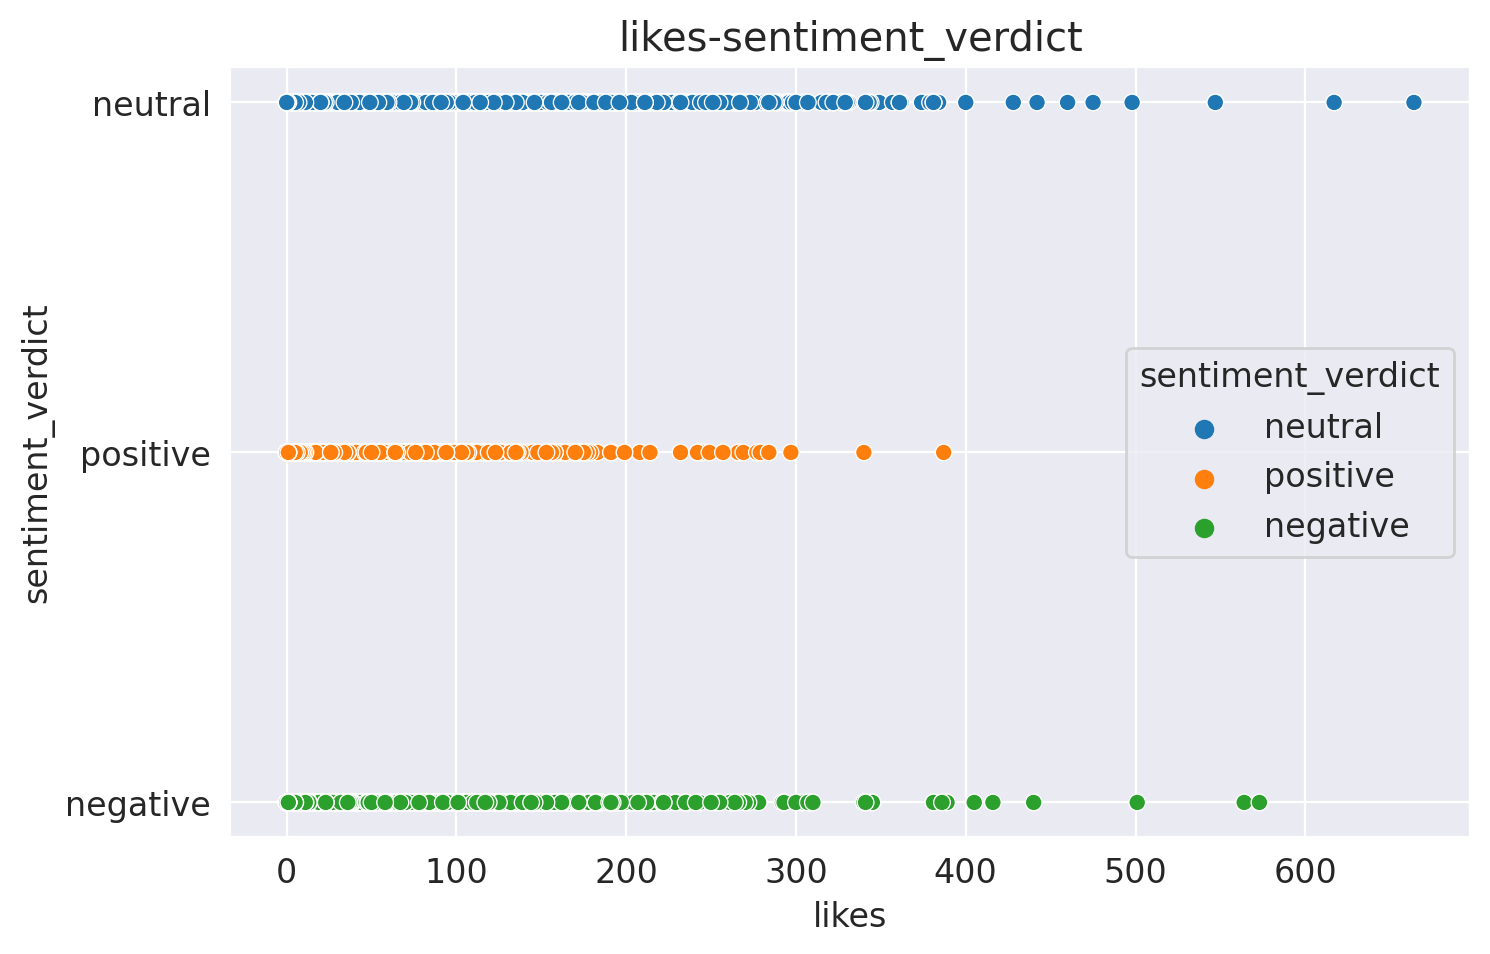

In [71]:
sns.scatterplot(x='likes', y='sentiment_verdict', data=df_comments, hue='sentiment_verdict')

plt.title('likes-sentiment_verdict')
plt.ylabel("sentiment_verdict")
plt.xlabel("likes")
plt.show()

По графику видно, что лайков действительно больше у негативных новостей. У позитивных заметно меньше

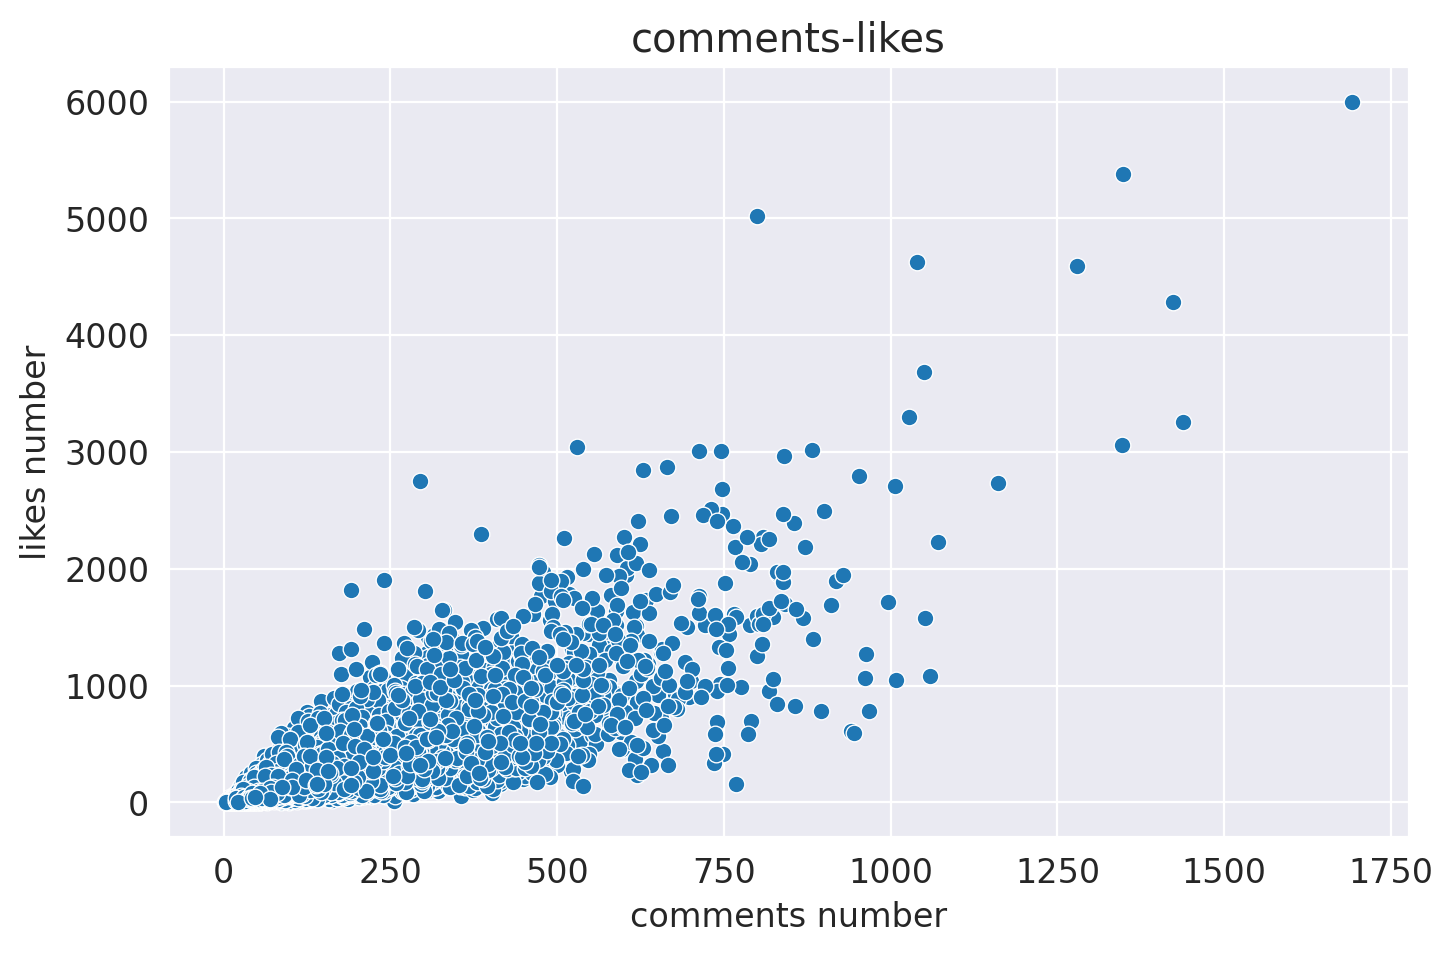

In [72]:
sns.scatterplot(x=df_comments.groupby('post_id')['id'].count().values,
                y=df_comments.groupby('post_id')['likes'].sum().values)

plt.title('comments-likes')
plt.ylabel("likes number")
plt.xlabel("comments number")
plt.show()

Правда. (см график)

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [94]:
u = df_comments['positivecount']
d = df_comments['negativecount'] + df_comments['neutralcount']

a = 1 + u
b = 1 + d

df_comments['sentiment_color'] = a / (a + b) - 1.65 * np.sqrt( a * b / ((a + b) ** 2 * (a + b + 1)))

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

In [100]:
df_comments[df_comments['sentiment_color'].notna()].sort_values('sentiment_color', axis=0)[-10:]

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,negativecount,neutralcount,positivecount,sentiment_color
2013279,19965739,19965364.0,2018-03-11 21:12:56,Что теперь будет? Что делать нам?,0.0,positive,0.960959,3.0,32.0,70.0,0.588533
2013278,19965733,19965364.0,2018-03-11 21:12:42,"Вот с этого бы и начал ,не зря я все-таки тебе...",0.0,positive,0.968186,3.0,32.0,70.0,0.588533
2013277,19965712,19965364.0,2018-03-11 21:10:57,"Да не ,не начались .Он тут давно отирается я н...",0.0,neutral,0.725037,3.0,32.0,70.0,0.588533
2013276,19965707,19965364.0,2018-03-11 21:10:03,"А к чему привязывать надо , интересно.К рублю ...",1.0,positive,0.971483,3.0,32.0,70.0,0.588533
2013275,19965693,19965364.0,2018-03-11 21:08:52,"Опа, кажется у жени началась истерика.Неужели ...",0.0,neutral,0.512190,3.0,32.0,70.0,0.588533
2013274,19965651,19965364.0,2018-03-11 21:04:38,Так были американцы на Луне или не были?,0.0,positive,0.671796,3.0,32.0,70.0,0.588533
2013273,19965650,19965364.0,2018-03-11 21:04:30,"У Зимбабве тоже стоит ,и не особо-то помогает....",0.0,positive,0.989159,3.0,32.0,70.0,0.588533
2013272,19965647,19965364.0,2018-03-11 21:03:50,"Да ладно тебе отмазыватся,соберись наконец.То ...",0.0,neutral,0.822614,3.0,32.0,70.0,0.588533
2013242,19965369,19965364.0,2018-03-11 20:28:10,А у великой сверхдержавной России даже подобно...,6.0,positive,0.978116,3.0,32.0,70.0,0.588533
2013291,19965859,19965364.0,2018-03-11 21:26:02,Да я и сейчас достаточно умен что бы тебя за н...,0.0,positive,0.991958,3.0,32.0,70.0,0.588533


__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [101]:
df_comments.groupby('sentiment_verdict')['sentiment_color'].mean()

sentiment_verdict
negative    0.041848
neutral     0.045398
positive    0.068025
Name: sentiment_color, dtype: float64

не поняла, что подразумевается под категорией новости. Но мой способ такой: группируем по вердиктам/категориям новостей, считаем среднее. Категория с самым высоким средним - самая позитивная

В нашем случае, категория positive самая позитивная (шок)

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

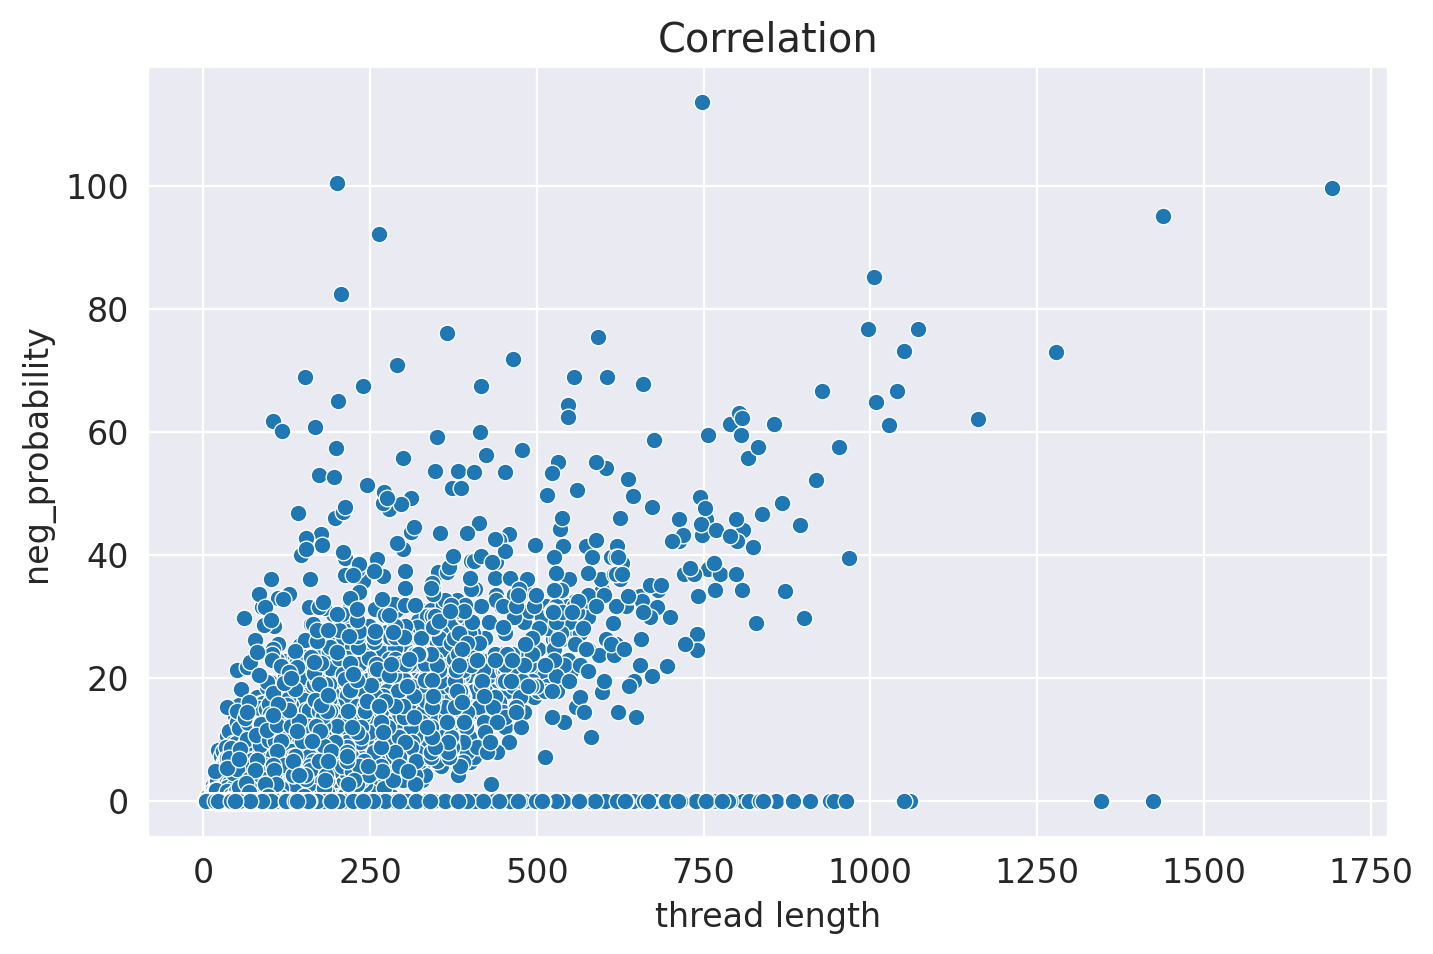

In [104]:
sns.scatterplot(x=df_comments.groupby('post_id')['id'].count().values,
                y=df_comments.groupby('post_id')['sentiment_color'].sum().values)

plt.title("Correlation")
plt.ylabel("neg_probability")
plt.xlabel("thread length")
plt.show()

На графике заметно более-менее распределение линейной регрессии. Можно провести линию на плоскости, которая с большой вероятностью опишет зависимость температуры комментария от длины треда

(точки внизу - объекты, для которых не посчитались кол-ва негативных/позитивных комментариев) долго работало :(